In [102]:
import os
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.dates as mdates
from scipy import interpolate
workdir= '/data/chanin'

In [33]:
def find_lag(y1, y2, max_lag):
    # Extract the two columns from the DataFrame
    series1 = y1
    series2 = y2

    # Initialize variables to store the maximum correlation and lag
    max_corr = 0
    lag_with_max_corr = None
    lags = range(-max_lag, max_lag + 1)
    cc =[]
    # Iterate through possible lag values
    for lag in lags:
        # Shift the second series by the lag value
        shifted_series2 = np.roll(series2, lag)

        # Compute the correlation coefficient
        corr = np.corrcoef(series1, shifted_series2)[0, 1]
        #print(corr)
        cc.append(corr)
        # Check if the current correlation is the maximum so far
        if np.absolute(corr) > np.absolute(max_corr):
            max_corr = corr
            lag_with_max_corr = lag
        if lag_with_max_corr == None:
            lag_with_max_corr = np.nan
            max_corr = np.nan
    return lag_with_max_corr,max_corr,cc,lags
def find_turning_points(arr):
    turning_points = []

    for i in range(1, len(arr) - 1):
        if (arr[i] > arr[i-1] and arr[i] > arr[i+1]) or (arr[i] < arr[i-1] and arr[i] < arr[i+1]):
            turning_points.append(i)

    return turning_points
# Example usage
# Assuming 'data' is your pandas DataFrame and 'col1' and 'col2' are the column names

### Read data

In [2]:
#Weater
weather_file = workdir+'/GPS/weather2009-2022.csv'
weather = pd.read_csv(weather_file)
weather.index = pd.to_datetime(weather['date'], format = '%Y-%m-%d')
day = 15
weather['T_min'] = weather['T_min'].str.replace(r'[^0-9.]', '', regex=True).astype(float)
for column in ['T_max','T_min','T_avr','P_max','P_min','P_avr','H_max','H_min','H_avr','wind_dir','Evap']:
    name = column+'SMA%d'%day
    weather[name] = weather[column].rolling(day, min_periods=1).mean()

In [3]:
#Prepare gps
file1 = 'Result_2010_CMU1.csv'
file2 = 'Height.csv'
#print(os.path.exists(file1),os.path.exists(file2))
h = pd.read_csv(file1)
H = pd.read_csv(file2)
h[['DOY','H-m']]
h['Date'] = pd.to_datetime(2010 * 1000 + h['DOY'], format='%Y%j')
h.index = pd.to_datetime(h['Date'], format = '%Y-%m-%d')
h['CMU1'] = h['H-m']
H.dropna(how='all', axis=1, inplace=True)
H.index = pd.to_datetime(H['Date'], format = '%Y-%m-%d')
#H[~H['Unnamed: 24'].isnull()]
cmu=pd.concat([H['CMU1'].loc['2005-01-01':'2009-12-31'], h['CMU1']], axis=0)
cmu = cmu.to_frame()
mean=cmu['CMU1'].mean()
cmu['demean'] = cmu['CMU1']-mean
day =15
cmu['GPS_SMA'] = cmu.CMU1.rolling(day, min_periods=1).mean()
cmu['GPS_SMAdemean'] = cmu.demean.rolling(day, min_periods=1).mean()


In [4]:
#rain GWL
rain = pd.read_csv('rain_gwl_2003_2022.csv')
rain.index = pd.to_datetime(rain['date'], format = '%Y-%m-%d')

In [5]:
weather=pd.concat([weather, cmu,rain], axis=1)

In [6]:
weather=weather.loc[:, ~weather.columns.duplicated()]
weather=weather.drop('Unnamed: 0', axis=1)

In [7]:
#Fix gps duplicate
gps=cmu[~cmu.duplicated()]
gps[gps.index.duplicated()]
#gps.index.is_unique
#gps=cmu['GPS_SMAdemean'].rename_axis('date')
#len(gps)
gps

,CMU1,demean,GPS_SMA,GPS_SMAdemean
Date,,,,
2005-01-01,308.8972,0.014907,308.897200,0.014907
2005-01-02,308.8914,0.009107,308.894300,0.012007
2005-01-03,NaN,NaN,308.894300,0.012007
2005-01-04,308.8911,0.008807,308.893233,0.010940
2005-01-05,308.8916,0.009307,308.892825,0.010532
...,...,...,...,...
2010-10-05,308.8662,-0.016093,308.867060,-0.015233
2010-10-06,308.8568,-0.025493,308.865587,-0.016706
2010-10-07,308.8565,-0.025793,308.864173,-0.018120


In [8]:
#groundwater
gw_all = pd.read_csv('CMLP.csv')
gw_all['date'] =  pd.to_datetime(gw_all['date'], format='%m/%d/%Y')
gw_all = gw_all.drop(columns=['no'])
gw_all.index = gw_all['date']
gw_all.dropna(how='all', axis=1, inplace=True)

In [11]:
#dvv CHTO
start_date = '2003-01-01'
end_date = '2023-01-01'
# Create a new datetime index with the specified start and stop dates
new_index = pd.date_range(start=start_date, end=end_date, freq='D')
#dvv
file='/data/chanin/CHTO_00_2003_2022/STR_2_8s_REF_a/03/005_DAYS/dvv_SMA30_IU.CHTO.00_IU.CHTO.00_coeff0.4.csv'
CHTO00_f3 = pd.read_csv(file)
CHTO00_f3.index = pd.to_datetime(CHTO00_f3['Unnamed: 0'], format = '%Y-%m-%d')

file ='/data/chanin/CHTO_00_2003_2022/STR_5_10s_REF_a/02/005_DAYS/dvv_SMA30_IU.CHTO.00_IU.CHTO.00_coeff0.4.csv'
CHTO00_f2 = pd.read_csv(file)
CHTO00_f2.index = pd.to_datetime(CHTO00_f2['Unnamed: 0'], format = '%Y-%m-%d')
#dvv_f2 = CHTO00_f2[CHTO00_f2['Coeff_']>= 0.4].dvv_1.rolling(day, min_periods=1).mean()
#dvv_f2 =dvv_f2.reindex(new_index)
file ='/data/chanin/CHTO_00_2003_2022/STR_20_40s_REF_a/01/005_DAYS/dvv_SMA30_IU.CHTO.00_IU.CHTO.00_coeff0.4.csv'
CHTO00_f1 = pd.read_csv(file)
CHTO00_f1.index = pd.to_datetime(CHTO00_f2['Unnamed: 0'], format = '%Y-%m-%d')

file = '/data/chanin/CHTO_10_2006_2022/STR_2_8s_rall/03/015_DAYS/dvv_SMA30_IU.CHTO.10_IU.CHTO.10_coeff0.4.csv'
CHTO10_f3 = pd.read_csv(file)
CHTO10_f3.index = pd.to_datetime(CHTO10_f3['Unnamed: 0'], format = '%Y-%m-%d')

weather['dvvCHTO00_f1']=CHTO00_f1['SMA_mean']
weather['dvvCHTO00_f2']=CHTO00_f2['SMA_mean']
#weather['dvv_f3_10']=CHTO10_f3['SMA_mean']
weather['dvvCHTO00_f3']=CHTO00_f3['SMA_mean']

In [22]:
#dvv T2 mean 'STR_20_40s'
projectT2 = 'CMAR_2012_2021'
stretchfol='STR_20_40s'
mov_stack=5
#component 0 = EN, 1=EZ, 2 = NZ
T2 = ['T2.CM31.--','T2.CM32.--','T2.CM33.--','T2.CM34.--','T2.CM35.--','T2.CM36.--']
component = ['mean','mean','mean','mean','mean','mean']
filterid=4

if filterid == 4:
    code='1'
elif filterid == 1:
    code='2'
   
day=30

for i,sta1 in enumerate(T2):
    #print(sta1)
    sta2 = sta1
    file = os.path.join(workdir,projectT2,stretchfol, "%02i" % filterid,"%03i_DAYS" % mov_stack,
                    "dvv_SMA%i_%s_%s_coeff%.1f.csv" % (day,sta1, sta2,0.4))
    df = pd.read_csv(file)
    df.index = pd.to_datetime(df['Unnamed: 0'], format = '%Y-%m-%d')
    weather['dvv%s_f%s'%(sta1.split(sep='.')[1],code)]=df['SMA_%s'%component[i]]
   


In [23]:
weather.loc['2012-05-01':'2012-05-06']


,date,r_mm,P_max,P_min,P_avr,T_max,T_min,T_avr,H_max,H_min,...,gwl,dvvCM31_f1,dvvCM32_f1,dvvCM33_f1,dvvCM34_f1,dvvCM35_f1,dvvCM36_f1,dvvCHTO00_f1,dvvCHTO00_f2,dvvCHTO00_f3
2012-05-01,2012-05-01,14.8,1009.5,1003.8,1006.46,35.0,23.5,28.4,91.0,50.0,...,5.053951,0.352046,-0.052516,-0.240238,NaN,-0.018340,0.170373,-0.155566,-0.223671,-0.089232
2012-05-02,2012-05-02,0.0,1009.5,1002.7,1006.25,37.0,24.6,30.7,83.0,44.0,...,5.063850,0.354931,-0.063846,-0.240015,-0.178192,0.003543,0.165105,-0.136441,-0.233802,-0.094053
2012-05-03,2012-05-03,1.6,1006.8,1000.2,1004.79,38.0,25.0,30.0,84.0,37.0,...,5.067300,0.350976,-0.075515,-0.230579,-0.193972,0.024454,0.162547,-0.118819,-0.244314,-0.098510
2012-05-04,2012-05-04,1.1,1006.8,1001.4,1004.90,36.9,23.6,29.1,88.0,40.0,...,5.072731,0.350289,-0.081800,-0.215841,-0.207144,0.038800,0.156866,-0.099021,-0.255799,-0.102844
2012-05-05,2012-05-05,28.9,1008.4,1002.7,1006.44,34.5,23.8,28.9,90.0,46.0,...,4.966935,0.348529,-0.082417,-0.208693,-0.217989,0.044993,0.146977,-0.089487,-0.267354,-0.107755
2012-05-06,2012-05-06,54.2,1008.2,1004.3,1006.55,24.3,22.4,23.7,93.0,86.0,...,4.760478,0.333399,-0.078444,-0.203448,-0.227410,0.042245,0.140724,-0.082974,-0.276518,-0.112045


## Analysis

need only positive lag, meaning y2 is ahead y1 the lag+ is rolling y2 to the right

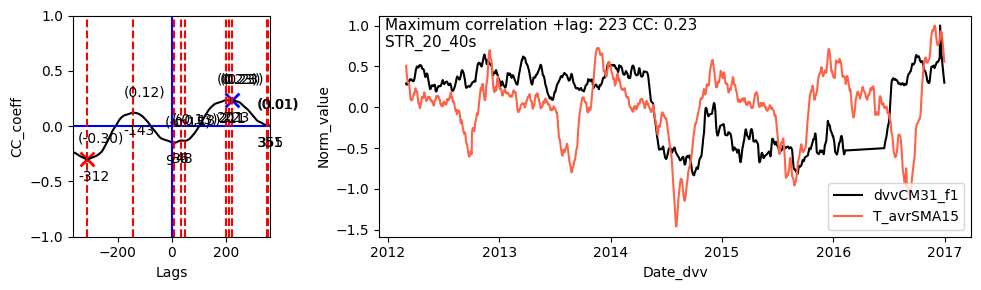

<Figure size 640x480 with 0 Axes>

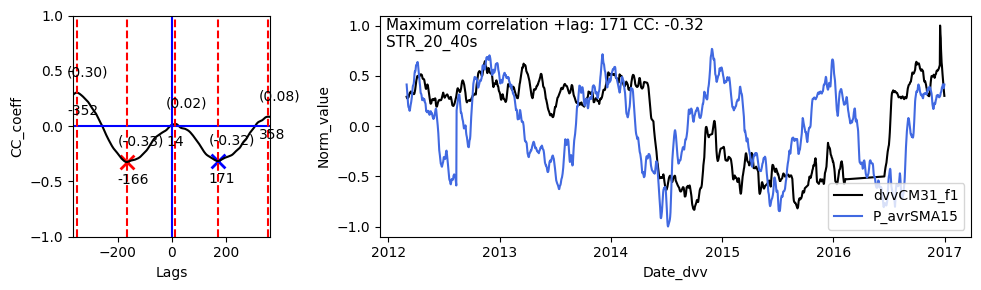

<Figure size 640x480 with 0 Axes>

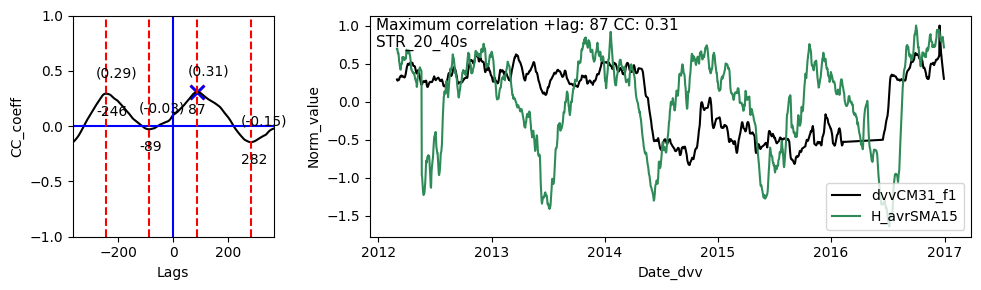

<Figure size 640x480 with 0 Axes>

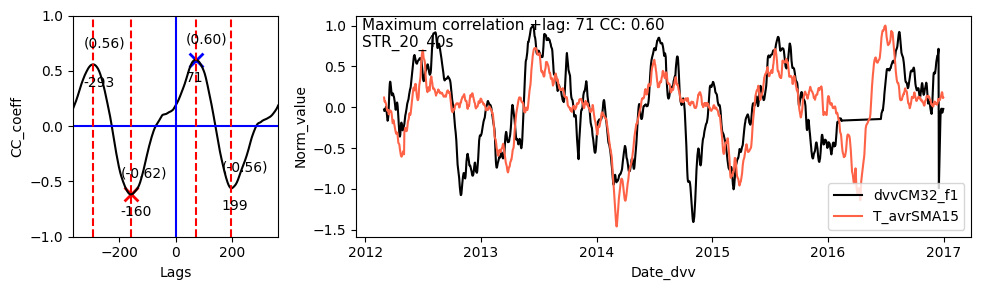

<Figure size 640x480 with 0 Axes>

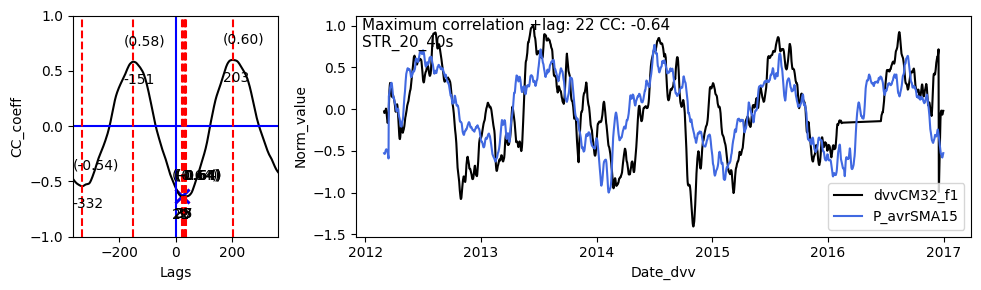

<Figure size 640x480 with 0 Axes>

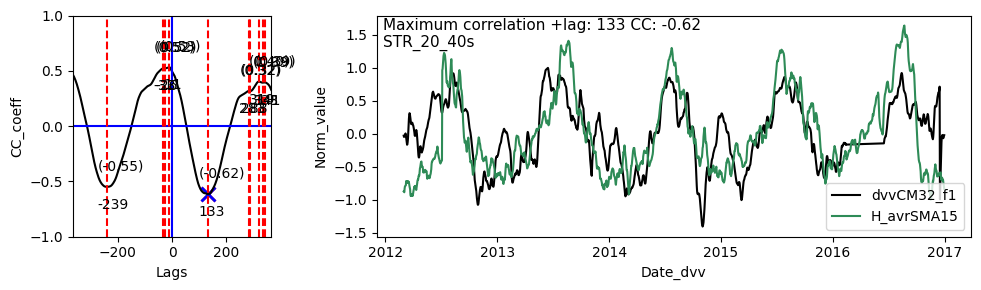

<Figure size 640x480 with 0 Axes>

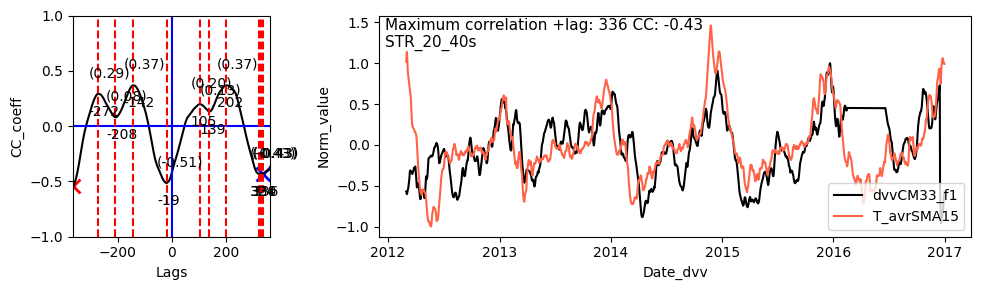

<Figure size 640x480 with 0 Axes>

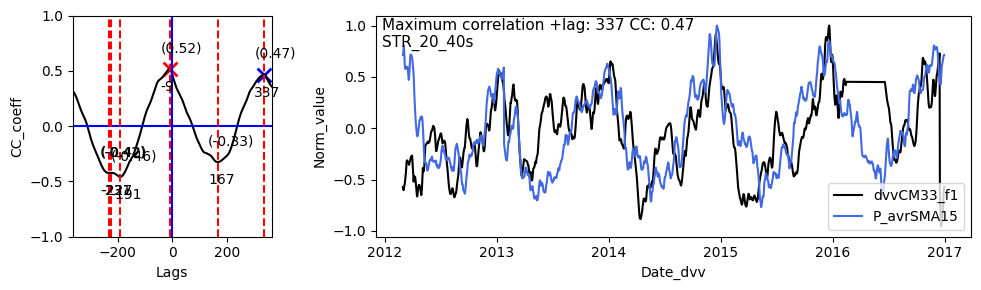

<Figure size 640x480 with 0 Axes>

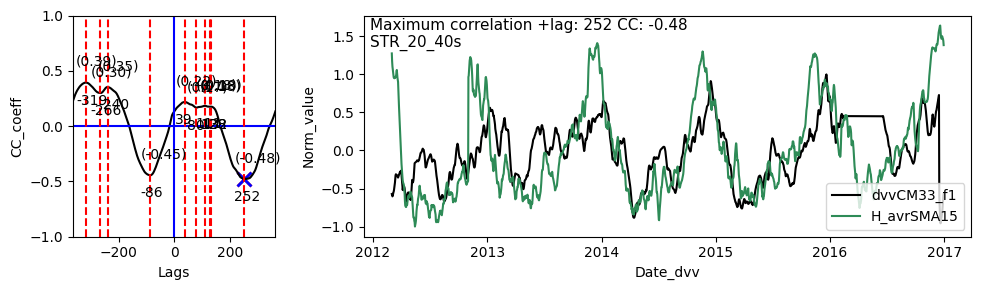

<Figure size 640x480 with 0 Axes>

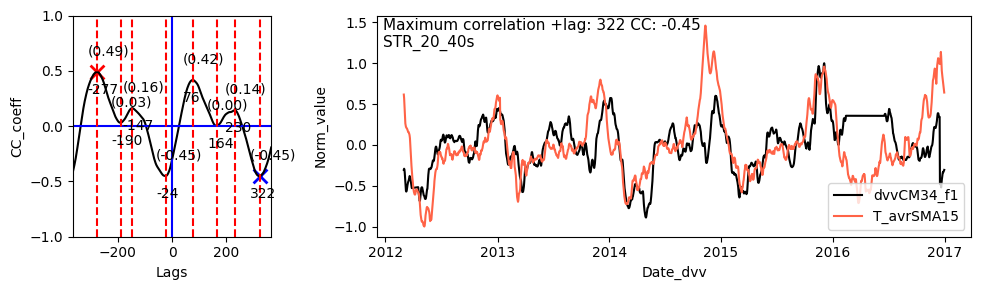

<Figure size 640x480 with 0 Axes>

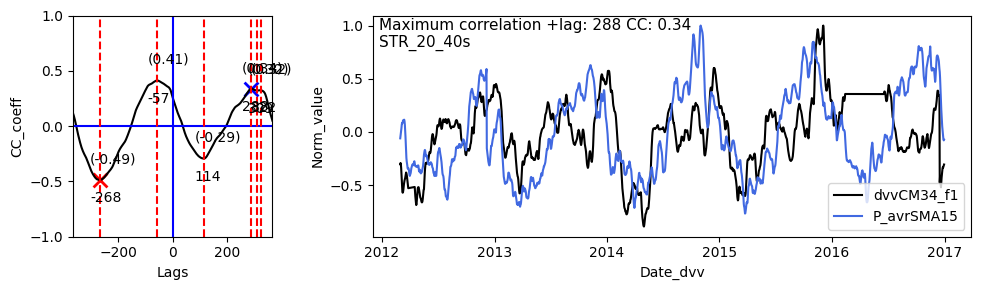

<Figure size 640x480 with 0 Axes>

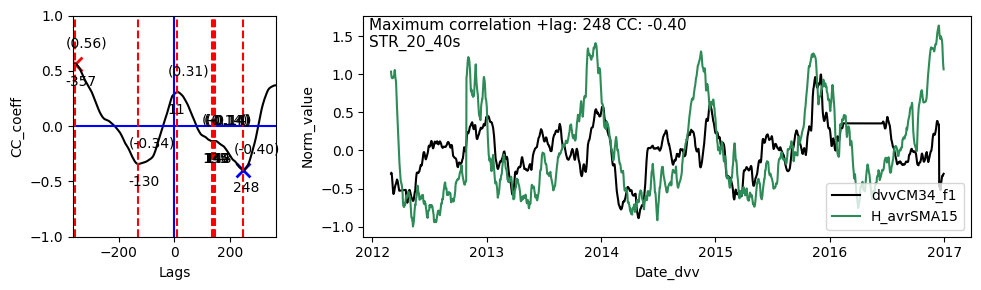

<Figure size 640x480 with 0 Axes>

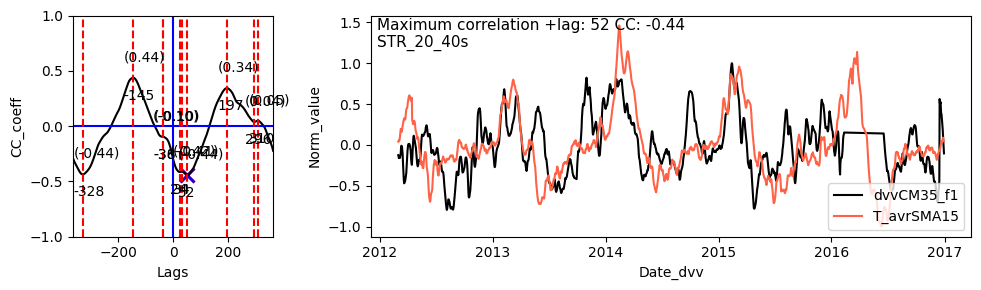

<Figure size 640x480 with 0 Axes>

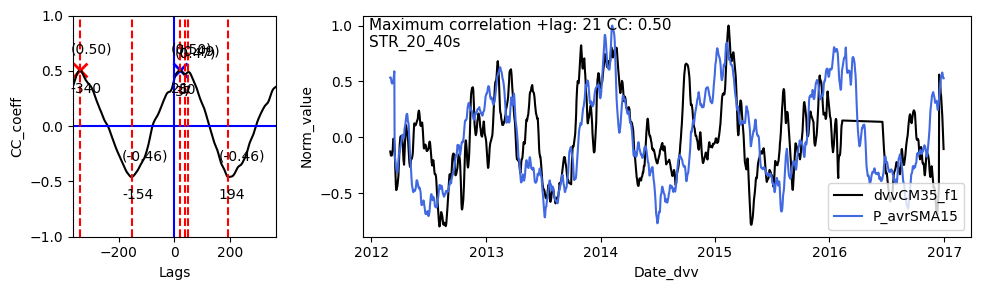

<Figure size 640x480 with 0 Axes>

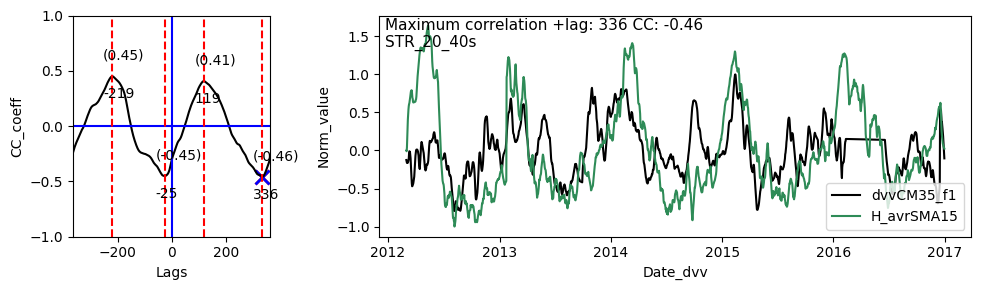

<Figure size 640x480 with 0 Axes>

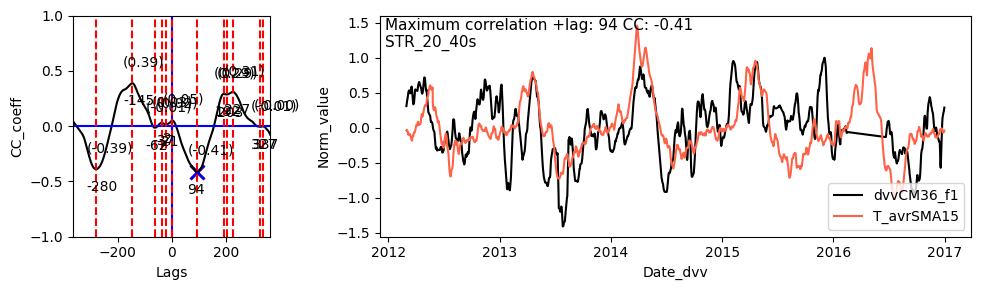

<Figure size 640x480 with 0 Axes>

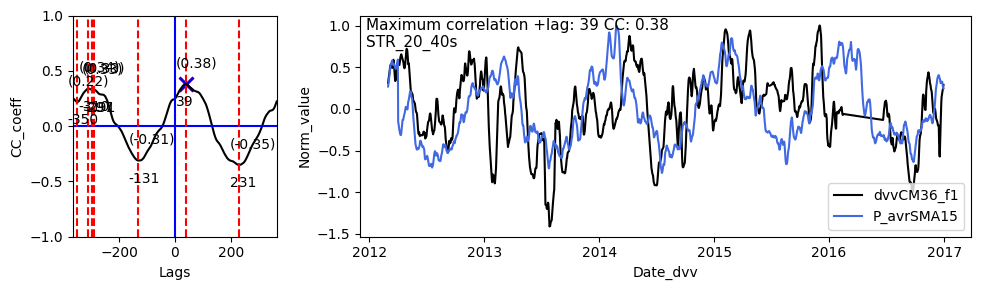

<Figure size 640x480 with 0 Axes>

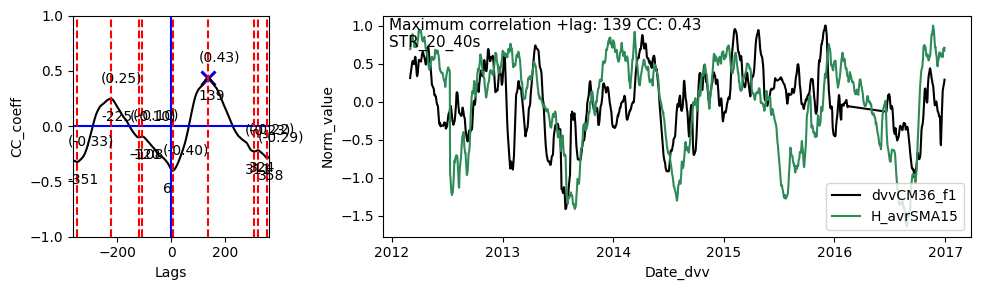

<Figure size 640x480 with 0 Axes>

In [147]:
delay = '+'
color_list=['tomato','royalblue','seagreen']
saveresult = os.path.join(workdir,projectT2,stretchfol)
for sta in T2:
    y1_data = 'dvv%s_f%s'%(sta.split(sep='.')[1],code)
    start='2012-03-01'
    stop='2016-12-30'
    w=['T_avr','P_avr','H_avr']

    for j,y2_data in enumerate(w):
        y2_data= y2_data+'SMA%d'%15
        y1=weather.loc[start:stop, y1_data].interpolate()
        #y1=dvv_f2.loc[start:stop]
        y2=weather.loc[start:stop, y2_data].interpolate()
        y1=np.roll(y1, -15)
        y2=np.roll(y2, -7) #for SMA15
        y1 = y1-np.mean(y1)
        y2 = y2-np.mean(y2)
        y1 =y1/y1.max()
        y2=y2/y2.max()
        max_lag = 365
        lag,max_cc,cc,lags = find_lag(y1, y2, max_lag)
        #print("Maximum correlation lag:", lag," CC: %.4f"% max_cc)
        fig = plt.figure(figsize=(10,3))
        gs = gridspec.GridSpec(1, 2, width_ratios=[1, 3]) 
        ax1 = plt.subplot(gs[0])
        plt.rcParams.update({'font.size': 10})
        plt.plot(lags, cc,color='k')
        
        tt=find_turning_points(cc)
        plt.axhline(y=0, color='b')
        plt.axvline(x=0, color='b')
        #plt.title('%s:shifted %s'%(y1_data,y2_data))
        plt.ylabel('CC_coeff')
        plt.xlabel('Lags')
        plt.xlim(-365,365)
        plt.ylim(-1,1)
        lags_tt=[]
        cc_tt=[]
        for i in tt:
            lags_tt.append(lags[i])
            cc_tt.append(cc[i])
            plt.text(lags[i]-35, cc[i]-0.2, lags[i], fontsize=10, color='k')
            plt.text(lags[i]-35, cc[i]+0.15, '(%.2f)'%cc[i], fontsize=10, color='k')
            plt.axvline(x=lags[i], color='r', linestyle='--')
        cc_positive=max(np.array(cc_tt)[np.array(lags_tt)> 0], key=abs)
        lag_positive=lags_tt[cc_tt.index(cc_positive)]
        plt.scatter(lag,max_cc,marker='x',color='r',linewidths=2,s=100)
        plt.scatter(lag_positive,cc_positive,marker='x',color='b',linewidths=2,s=100)
        #delay positive max_cc
        
        ax2 = plt.subplot(gs[1])

        #fig = plt.figure(figsize=(8,2))
        xt=weather.loc[start:stop, y1_data].index
        ax2.plot(xt,y1,label=y1_data,color='k')
        if delay == '+':
            selected_cc=cc_positive
            selected_lag=lag_positive
        elif delay == 'any':
            selected_lag=lag
            selected_cc=max_cc
        if selected_cc >0:
            flip=1
        elif selected_cc < 0 :
            flip = -1
        plt.ylabel('Norm_value')
        plt.xlabel('Date_dvv')
        ax2.plot(xt,np.roll(y2, selected_lag)*flip,label=y2_data,c=color_list[j])
        ax2.text(.01, .99,"Maximum correlation %slag: %d CC: %.2f \n%s"% (delay,selected_lag,selected_cc,stretchfol),
                 fontsize=11,ha='left', va='top', transform=ax2.transAxes)
        ax2.legend(loc='lower right')
        plt.tight_layout()
        plt.show()
        plt.savefig(saveresult+'/'+'CC_%s_%s_%s.png'%(sta1.split(sep='.')[1],delay,y2_data))
        

In [148]:
import imageio
factor='T_avr15'
png_dir = saveresult
images = []
for file_name in sorted(os.listdir(png_dir)):
    if file_name.endswith('T_avr15.png'):
        file_path = os.path.join(png_dir, file_name)
        images.append(imageio.imread(file_path))

# Make it pause at the end so that the viewers can ponder
for _ in range(10):
    images.append(imageio.imread(file_path))

imageio.mimsave(saveresult+'/'+ '%s.gif'%factor, images)

ModuleNotFoundError: No module named 'imageio'

In [127]:
weather.loc[start:stop, y2_data].index

DatetimeIndex(['2012-03-01', '2012-03-02', '2012-03-03', '2012-03-04',
               '2012-03-05', '2012-03-06', '2012-03-07', '2012-03-08',
               '2012-03-09', '2012-03-10',
               ...
               '2016-12-21', '2016-12-22', '2016-12-23', '2016-12-24',
               '2016-12-25', '2016-12-26', '2016-12-27', '2016-12-28',
               '2016-12-29', '2016-12-30'],
              dtype='datetime64[ns]', length=1766, freq='D')

In [29]:
y2_data='H_avrSMA15'
#y2_data='gwl'

stop_0='2014-01-01'
start_0='2012-01-01'

w=['T_max','T_min','P_max','H_max','H_min','H_avr','wind_dir','Evap']
cc_mov=[]
delay_mov=[]
step=0.5
for ny in range(21):
    start=datetime.strptime(start_0, '%Y-%m-%d')+ny*timedelta(365)*step
    stop=datetime.strptime(stop_0, '%Y-%m-%d')+ny*timedelta(365)*step
    for y1_data in ['dvv_f3_00']:
        #y2_data= y2_data+'SMA%d'%15
        y1=weather.loc[start:stop, y1_data].interpolate()
        y1=np.roll(y1, -15)
        y2=weather.loc[start:stop, y2_data].interpolate()
        y2=np.roll(y2, -7) #for SMA15
        #y1=dvv_f2.loc[start:stop]
        
        y1 = y1-np.mean(y1)
        y2 = y2-np.mean(y2)
        y1 =y1/y1.max()
        y2=y2/y2.max()
        max_lag = 365
        lag,max_cc,cc,lags = find_lag(y1, y2, max_lag)
        delay_mov.append(lag)
        cc_mov.append(max_cc)
        print("Maximum correlation lag:", lag)
        fig = plt.figure(figsize=(8,4))
        ax1 = fig.add_subplot(121)
        plt.rcParams.update({'font.size': 12})
        ax1.plot(lags, cc,color='k')
        tt=find_turning_points(cc)
        ax1.axhline(y=0, color='b')
        ax1.axvline(x=0, color='b')
        fig.suptitle('%s:shifted %s %s:%s'%(y1_data,y2_data,start,stop))
        ax1.set_ylabel('CC_coeff')
        ax1.set_xlabel('Lags')
        ax1.set_xlim(-365,365)
        ax1.set_ylim(-1,1)
        for i in tt:
            print(lags[i])
            plt.text(lags[i]-35, cc[i]-0.1, lags[i], fontsize=10, color='k')
            plt.text(lags[i]-35, cc[i]+0.1, '(%.2f)'%cc[i], fontsize=10, color='k')
            plt.axvline(x=lags[i], color='r', linestyle='--')
        #plt.show()
        for i in tt:
            if lags[i] > 0:
                first_positive = lags[i]
                break
                
        ax2 = fig.add_subplot(122)
        ax2.plot(y1,label='dvv_f3')
        ax2.plot(y2,label='T_avr',c='magenta')
        plt.legend()
        plt.show()
        #print(len(cc_mov))
        

KeyError: 'dvv_f3_00'

In [19]:

mask = np.isnan(cc_mov)
delay_mov = np.where(mask, np.nan, delay_mov)
yr_window = 2013+np.arange(0,21)*0.5
fig = plt.figure(figsize=(8,2))
plt.ylabel('CC_coeff')
plt.xlabel('Sliding window')
plt.plot(yr_window,cc_mov,'-o')
plt.xticks(np.arange(yr_window.min(),yr_window.max()+1,1))
plt.axhline(y=np.nanmean(cc_mov), color='r', linestyle='--')
plt.text(2018, np.nanmean(cc_mov)- 0.1, 'Avr.CC %.2f'%np.nanmean(cc_mov), fontsize=10, color='k')
fig = plt.figure(figsize=(8,2))
plt.ylabel('Delay (days)')
plt.xlabel('Sliding window')
plt.plot(yr_window,delay_mov,'-o')
plt.xticks(np.arange(yr_window.min(),yr_window.max()+1,1))
plt.axhline(y=np.nanmean(delay_mov), color='r', linestyle='--')
plt.text(2018, np.nanmean(delay_mov)- 5, 'Avr.CC %.2f'%np.nanmean(delay_mov), fontsize=10, color='k')

NameError: name 'cc_mov' is not defined

In [ ]:
len(cc_mov)
#yr_window 

In [315]:
weather.loc[datetime.strptime(start, '%Y-%m-%d')+timedelta(366):datetime.strptime(stop, '%Y-%m-%d')+timedelta(365), y1_data]

2005-01-01    0.174842
2005-01-02    0.170504
2005-01-03    0.171505
2005-01-04    0.172506
2005-01-05    0.177177
                ...   
2006-12-28    0.497164
2006-12-29    0.503504
2006-12-30    0.513847
2006-12-31    0.529863
2007-01-01    0.532866
Freq: D, Name: dvv_f2, Length: 731, dtype: float64

In [190]:
np.corrcoef(y1.interpolate(), y2.interpolate())

array([[nan, nan],
       [nan,  1.]])

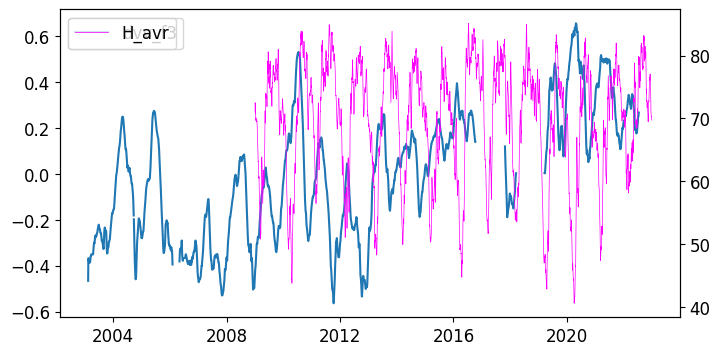

In [84]:
fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(111)
ax1.plot(weather.dvv_f3_00,label='dvv_f3')
plt.legend()
ax2 = ax1.twinx()
ax2.plot(weather.H_avrSMA15,label='H_avr',color='magenta',lw=0.5)
plt.legend()

In [161]:
weather

,date,r_mm,P_max,P_min,P_avr,T_max,T_min,T_avr,H_max,H_min,...,wind_dirSMA15,EvapSMA15,CMU1,demean,GPS_SMA,GPS_SMAdemean,gwlout_mm,gwl,dvv_f3,dvv_f3_10
2003-01-01,2003-01-01,5.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-21.600000,6.978400,NaN,NaN
2003-01-02,2003-01-02,0.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-24.690120,6.975310,NaN,NaN
2003-01-03,2003-01-03,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-24.564521,6.975435,NaN,NaN
2003-01-04,2003-01-04,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-24.439561,6.975560,NaN,NaN
2003-01-05,2003-01-05,11.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-69.915237,6.930085,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,2022-12-27,0.0,1018.4,1011.0,1015.31,29.9,17.6,23.0,92.0,43.0,...,197.333333,2.681333,NaN,NaN,NaN,NaN,-3911.428268,3.088572,NaN,-0.160638
2022-12-28,2022-12-28,0.0,1018.0,1012.1,1015.47,29.5,17.1,22.9,92.0,45.0,...,195.333333,2.785333,NaN,NaN,NaN,NaN,-3891.530766,3.108469,NaN,-0.157599
2022-12-29,2022-12-29,0.0,1018.9,1012.3,1016.18,29.8,18.0,23.1,89.0,45.0,...,188.666667,2.754667,NaN,NaN,NaN,NaN,-3871.734483,3.128266,NaN,-0.154378
2022-12-30,2022-12-30,0.0,1020.2,1014.0,1017.00,28.6,19.2,23.5,88.0,50.0,...,181.333333,2.724667,NaN,NaN,NaN,NaN,-3852.038903,3.147961,NaN,-0.151214


Maximum correlation lag: 95
-286
-124
95
243


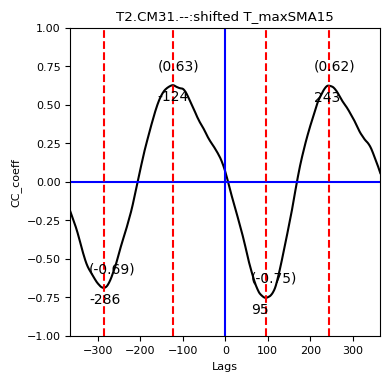

Maximum correlation lag: 75
-299
-55
75
332


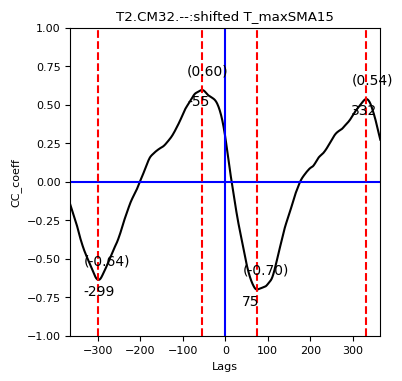

Maximum correlation lag: 51
-320
-175
-163
-155
-136
-107
51
208
220
252
301
307


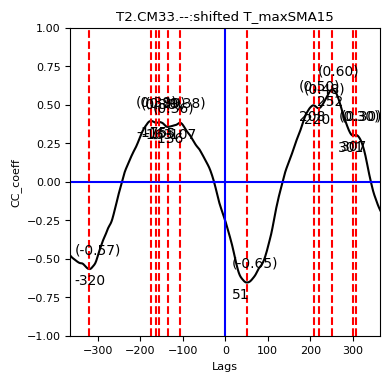

Maximum correlation lag: 105
-269
-83
-54
-41
105
243
271
320
336
340


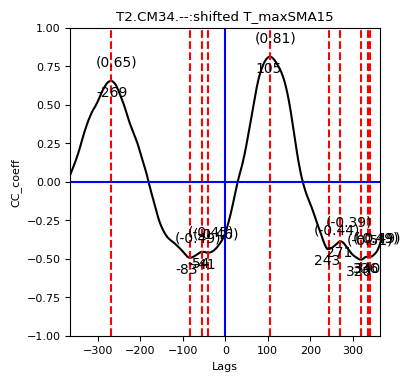

Maximum correlation lag: 88
-290
-143
-133
-103
88
244


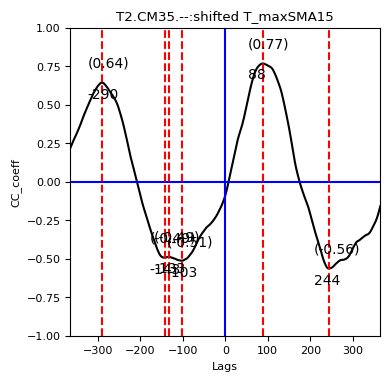

Maximum correlation lag: 227
-322
-317
-273
-134
-40
8
103
227
326


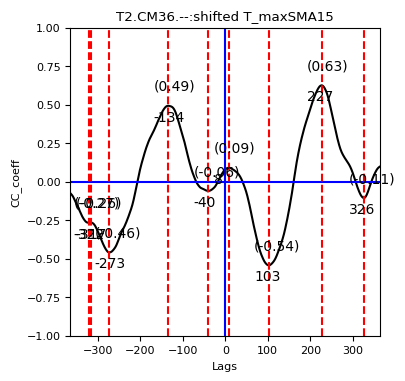

In [39]:
#y1_data='T_minSMA15'
#y2_data='EvapSMA15'
start='2018-10-01'
stop='2021-11-30'
w=['T_max','T_min','T_avr','H_max','H_min','H_avr','wind_dir','Evap']

project = 'CMAR_2012_2021'
stretchfol = 'STR_2_20'
#saveresult = os.path.join(workdir,project,stretchfol)
mov_stack=5
limit_coeff=0.4
low  = [0,0.5,1,0.5,0.1]
high = [0,1,2,2,0.5]
component = ['NZ','NZ','EN','EZ','EN','NZ']
filterid=4
shift=[0,0,-20,0,0,0]
day=30
for i,sta1 in enumerate(['T2.CM31.--','T2.CM32.--','T2.CM33.--','T2.CM34.--','T2.CM35.--','T2.CM36.--']):
    sta2 = sta1
    file = os.path.join(workdir,project,stretchfol, "%02i" % filterid,"%03i_DAYS" % mov_stack,
                    component[i],"SMA%i_%s_%s_coeff%.1f.csv" % (day,sta1, sta2,0.4))
    df = pd.read_csv(file)
    df.index = pd.to_datetime(df['Unnamed: 0'], format = '%Y-%m-%d')
    #ax1.plot(df['SMA'].index- timedelta(days=shift[i]+day/2),df['SMA'],linewidth=3,label=sta1[3:8]+'_'+component[i])
    #factor_list=['T_max','T_min','P_max','H_max']
    factor_list=['T_max']
    for j,y2_data in enumerate(factor_list):
        y2_data= y2_data+'SMA%d'%15
        y1_data=sta1
        #y1=weather.loc[start:stop, y1_data]
        y1=(df['SMA'].reindex(new_index)).loc[start:stop]
        y2=weather.loc[start:stop, y2_data]
        y1 = y1-np.mean(y1)
        y2 = y2-np.mean(y2)
        y1 =y1/y1.max()
        y2=y2/y2.max()
        max_lag = 365
        lag,max_cc,cc,lags = find_lag(y1.interpolate(), y2, max_lag)
        print("Maximum correlation lag:", lag)
        fig = plt.figure(figsize=(4,4))
        plt.rcParams.update({'font.size': 8})
        plt.plot(lags, cc,color='k')
        tt=find_turning_points(cc)
        plt.axhline(y=0, color='b')
        plt.axvline(x=0, color='b')
        plt.title('%s:shifted %s'%(y1_data,y2_data))
        plt.ylabel('CC_coeff')
        plt.xlabel('Lags')
        plt.xlim(-365,365)
        plt.ylim(-1,1)
        for k in tt:
            print(lags[k])
            plt.text(lags[k]-35, cc[k]-0.1, lags[k], fontsize=10, color='k')
            plt.text(lags[k]-35, cc[k]+0.1, '(%.2f)'%cc[k], fontsize=10, color='k')
            plt.axvline(x=lags[k], color='r', linestyle='--')
        plt.show()

Maximum correlation lag: 102
-280
-140
-135
-121
102
257
316
325


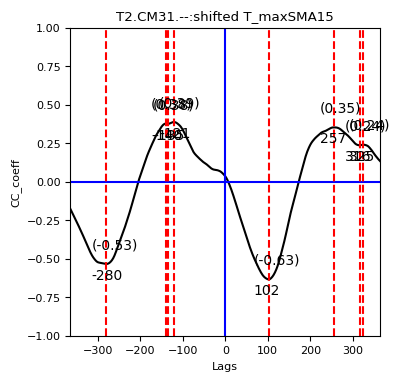

Maximum correlation lag: 90
-284
-149
-134
-124
-84
-24
90
227
256
328


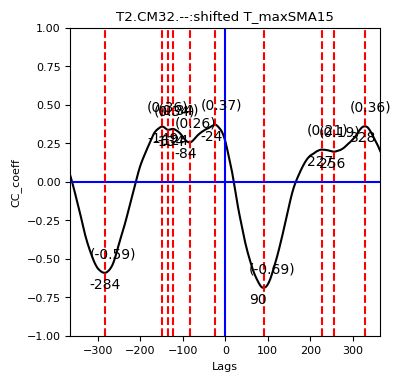

Maximum correlation lag: 29
-336
-175
-161
-148
29
240


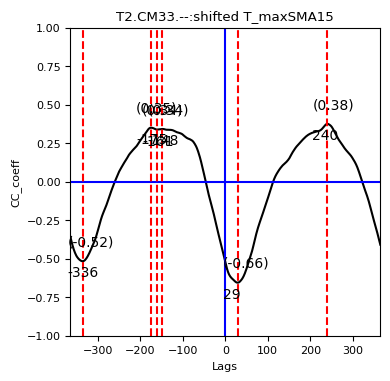

Maximum correlation lag: 97
-271
-122
-114
-103
-99
-49
97
268
270
327


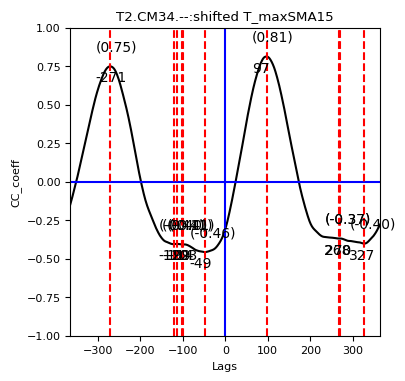

Maximum correlation lag: 90
-286
-131
-80
-70
90
241
282
285


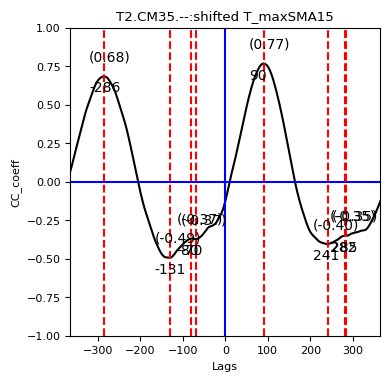

Maximum correlation lag: 100
-274
-155
-61
-3
100
208
306
355


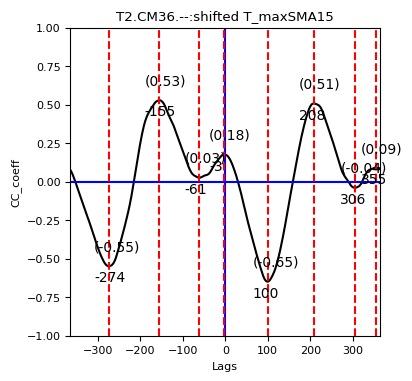

In [40]:
#y1_data='T_minSMA15'
#y2_data='EvapSMA15'
start='2012-10-01'
stop='2017-11-30'
w=['T_max','T_min','T_avr','H_max','H_min','H_avr','wind_dir','Evap']

project = 'CMAR_2012_2021'
stretchfol = 'STR_2_20'
#saveresult = os.path.join(workdir,project,stretchfol)
mov_stack=5
limit_coeff=0.4
low  = [0,0.5,1,0.5,0.1]
high = [0,1,2,2,0.5]
component = ['NZ','NZ','EN','EZ','EN','NZ']
filterid=4
shift=[0,0,-20,0,0,0]
day=30
for i,sta1 in enumerate(['T2.CM31.--','T2.CM32.--','T2.CM33.--','T2.CM34.--','T2.CM35.--','T2.CM36.--']):
    sta2 = sta1
    file = os.path.join(workdir,project,stretchfol, "%02i" % filterid,"%03i_DAYS" % mov_stack,
                    component[i],"SMA%i_%s_%s_coeff%.1f.csv" % (day,sta1, sta2,0.4))
    df = pd.read_csv(file)
    df.index = pd.to_datetime(df['Unnamed: 0'], format = '%Y-%m-%d')
    #ax1.plot(df['SMA'].index- timedelta(days=shift[i]+day/2),df['SMA'],linewidth=3,label=sta1[3:8]+'_'+component[i])
    #factor_list=['T_max','T_min','P_max','H_max']
    factor_list=['T_max']
    for j,y2_data in enumerate(factor_list):
        y2_data= y2_data+'SMA%d'%15
        y1_data=sta1
        #y1=weather.loc[start:stop, y1_data]
        y1=(df['SMA'].reindex(new_index)).loc[start:stop]
        y2=weather.loc[start:stop, y2_data]
        y1 = y1-np.mean(y1)
        y2 = y2-np.mean(y2)
        y1 =y1/y1.max()
        y2=y2/y2.max()
        max_lag = 365
        lag,max_cc,cc,lags = find_lag(y1.interpolate(), y2, max_lag)
        print("Maximum correlation lag:", lag)
        fig = plt.figure(figsize=(4,4))
        plt.rcParams.update({'font.size': 8})
        plt.plot(lags, cc,color='k')
        tt=find_turning_points(cc)
        plt.axhline(y=0, color='b')
        plt.axvline(x=0, color='b')
        plt.title('%s:shifted %s'%(y1_data,y2_data))
        plt.ylabel('CC_coeff')
        plt.xlabel('Lags')
        plt.xlim(-365,365)
        plt.ylim(-1,1)
        for k in tt:
            print(lags[k])
            plt.text(lags[k]-35, cc[k]-0.1, lags[k], fontsize=10, color='k')
            plt.text(lags[k]-35, cc[k]+0.1, '(%.2f)'%cc[k], fontsize=10, color='k')
            plt.axvline(x=lags[k], color='r', linestyle='--')
        plt.show()

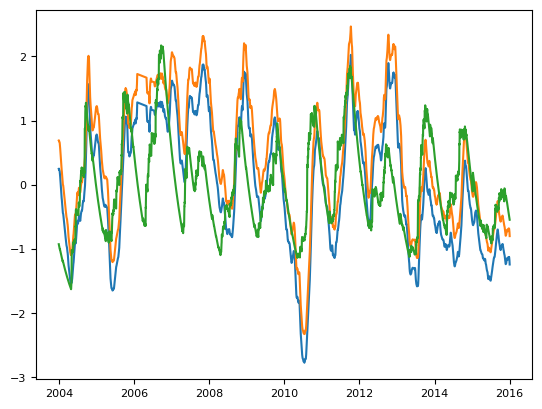

In [271]:
gwl=(weather['dvv_f3']*-4.375).loc['2004-01-01':'2016-01-01'].interpolate()
plt.plot(gwl-gwl.mean())
plt.plot(gwl)
gwe=weather['gwl'].loc['2004-01-01':'2016-01-01']
plt.plot((gwe-gwe.mean())*-1)
gwl.to_csv('dvv_f3.csv', index=True)

In [259]:
weather['r_mm'].loc['2004-01-01':'2016-01-01'].to_csv('rain_dvv_f3.csv', index=True)

In [260]:
len(weather['r_mm'].loc['2004-01-01':'2016-01-01'])

4384

In [261]:
len(gwl)

4384